    
# DATA DAY TRAINING: Intro to Python (data science workflow)

Topics to cover:

(i) Import data (from web and CSV files)

(ii) Clean and merge datasets

(iii) Exploratory data analysis

(iv) Visualization and modelling

We will cover this topic while exploring how life satisfaction in OECD countries varies with GNI per capita.

#### 1. Import libraries

Python provides several ways to import modules:

- import XYZ as x (to import the library XYZ abbreviated as x)
- import XYZ.xyz as x (to import module xyz (abbreviated as x from the library XYZ) 
- from XYZ import a, b, c (to import modules a, b, and c from library XYZ) 

You will notice pandas as one of the libraries we have imported along with some others.

Pandas is an open source library that has become the de facto tool in Python for data munging. Pandas allows us to present data in a tabular form with rows and columns (by storing data in a python object called a dataframe)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import wb
import numpy as np
import statsmodels.api as sm
from matplotlib.pyplot import figure
#import geopandas as gpd

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#### 1.1 Quick demo of pulling WDI data from the web
We're using Pandas Datareader: a third-party library that makes it easy to pull data from APIs into a Pandas dataframe.

Use it to pull live data from Yahoo! Finance, World Bank and others.


| Function | Task Performed |
|----|---|
| wb.get_countries()  | List available countries, with their country codes, income levels etc. |
| wb.search()  | Query the available indicators using a search term. |
| wb.WorldBankReader()  | A class for downloading data series. |


In [2]:
# Find the GNI per capita indicator, get its ID number

result = wb.search(string="GNI per capita, Atlas",field = 'name')
result

,id,name,source,sourceNote,sourceOrganization,topics,unit
8496,NY.GNP.PCAP.CD,"GNI per capita, Atlas method (current US$)",World Development Indicators,GNI per capita (formerly GNP per capita) is th...,"b'World Bank national accounts data, and OECD ...",Economy & Growth,


In [0]:
# Make a note of the indicator ID
GNI_ID = 'NY.GNP.PCAP.CD'

In [4]:
# Get a list of countries and clean it up
countries = wb.get_countries()
countries.head()

,adminregion,capitalCity,iso3c,incomeLevel,iso2c,latitude,lendingType,longitude,name,region
0,,Oranjestad,ABW,High income,AW,12.51670,Not classified,-70.0167,Aruba,Latin America & Caribbean
1,South Asia,Kabul,AFG,Low income,AF,34.52280,IDA,69.1761,Afghanistan,South Asia
2,,,AFR,Aggregates,A9,NaN,Aggregates,NaN,Africa,Aggregates
3,Sub-Saharan Africa (excluding high income),Luanda,AGO,Lower middle income,AO,-8.81155,IBRD,13.2420,Angola,Sub-Saharan Africa
4,Europe & Central Asia (excluding high income),Tirane,ALB,Upper middle income,AL,41.33170,IBRD,19.8172,Albania,Europe & Central Asia


In [5]:
#Select only those observations and columns we need: 
countries = countries[countries.incomeLevel != 'Aggregates']
countries = countries[['name', 'iso3c','incomeLevel']]
countries.head()

,name,iso3c,incomeLevel
0,Aruba,ABW,High income
1,Afghanistan,AFG,Low income
3,Angola,AGO,Lower middle income
4,Albania,ALB,Upper middle income
5,Andorra,AND,High income


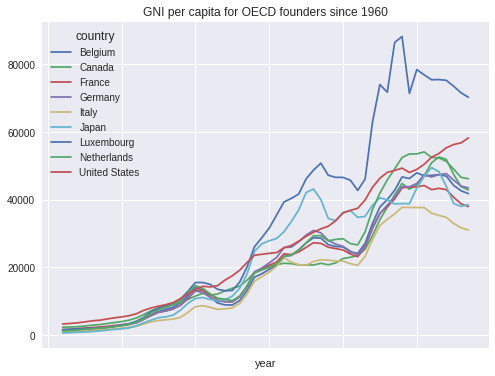

In [6]:
# Let's plot GNI per capita since 1960 for the OECD countries

OECD_founders = ['Belgium','France','Germany','Italy','Luxembourg','Netherlands','United States',
                'Canada','Japan']
OECD_founder_codes = countries.iso3c[countries.name.isin(OECD_founders)]

# Create a reader object, pass it the data ID and country codes we want

reader = wb.WorldBankReader(symbols=GNI_ID,countries = OECD_founder_codes,start=1960)
GNI_capita = reader.read()
GNI_capita.head()

GNI_capita = GNI_capita.unstack(level=0)[GNI_ID]
GNI_capita.head()

GNI_capita.plot(figsize=[8,6])
plt.title('GNI per capita for OECD founders since 1960');

#### 2. Combine income and life satisfaction data for 2015
Incomes have risen sharply. But does that translate into more life satisfaction, and are richer countries happier?

Let's do a cross-sectional analysis for a single year. 


#### 2.1 Import and clean up the OECD life satisfaction survey

In [0]:
# Read data from a CSV file using Pandas

CSV_path = 'https://raw.githubusercontent.com/worldbank/python-101/master/notebooks/BLI2015.csv'
life_sat = pd.read_csv(CSV_path)

Just like in STATA and other statistical packages, its straightfoward to use existing resources to manipulate a dataframe once its loaded. For instance, you can do the following:

- subset the data based on columns (e.g., select a subset of columns) or based on some logical condition.
- rename columns
- change data types
- create new variables based on other variables
- merging/joining dataframes
- plus more

In the cells below, you will see how some of this works:

In [0]:
# Keep relevant observations and columns discarding the rest

life_sat = life_sat[(life_sat.Inequality == "Total") & (life_sat.Indicator == 'Life satisfaction')]
life_sat = life_sat[['Country','LOCATION','Value']]

In [0]:
# Remove two values that don't match across datasets

life_sat = life_sat[~life_sat.Country.str.contains("OECD")]
life_sat = life_sat[~life_sat.Country.str.contains("Korea")]

# Rename columns, using the inplace option and set it to True which tells pandas to modify the existing dataframe. By default, when you perfom an action on a pandas dataframe, it returns a new dataframe.
life_sat.rename(columns = {'Country': 'country', 'LOCATION':'iso3c', 'Value':'life_satisfaction'},inplace=True)

In [10]:
# Inspect the dataframe: 
life_sat.head()

,country,iso3c,life_satisfaction
2669,Australia,AUS,7.3
2670,Austria,AUT,6.9
2671,Belgium,BEL,6.9
2672,Canada,CAN,7.3
2673,Czech Republic,CZE,6.5


#### 2.2 Get GNI per capita for OECD countries in 2015

In [0]:
# Read in the data

OECD_country_codes = life_sat.iso3c
reader = wb.WorldBankReader(symbols = GNI_ID, countries = OECD_country_codes, start = 2015, end = 2015)
GNI_OECD = reader.read()


In [0]:
# Clean up the dataframe and rename column

GNI_OECD2 = GNI_OECD.reset_index()
GNI_OECD = GNI_OECD2
GNI_OECD.rename(columns={'NY.GNP.PCAP.CD':'GNI_per_capita'},inplace=True)

In [13]:
#Inspect the dataframe

GNI_OECD.head()

,country,year,GNI_per_capita
0,Australia,2015,60360
1,Austria,2015,47630
2,Belgium,2015,44230
3,Brazil,2015,10090
4,Canada,2015,47460


#### 2.3 Merge the datasets

In [0]:
# Merge the datasets, keeping only the columns we need
df = pd.merge(life_sat, GNI_OECD,on='country')
df = df[['country','life_satisfaction','GNI_per_capita']]

In [15]:
# Inspect the dataframe 
df.head()

,country,life_satisfaction,GNI_per_capita
0,Australia,7.3,60360
1,Austria,6.9,47630
2,Belgium,6.9,44230
3,Canada,7.3,47460
4,Czech Republic,6.5,18250


### 3. Visualize a scatterplot

Python has extensive data visualization capabilities from the good old static plots to the more cool interaactive visualization. The base package for the plotting in Python is the [Matplotlib](https://matplotlib.org). They are other up and coming packages which are built on top of Matplotlib such as [seaborn](https://seaborn.pydata.org) which offers more visually appealing plots and extra functionalities. Also, Pandas has also built in plotting capabilities. If you need interactive visualizations, then [Bokeh](https://bokeh.pydata.org/en/latest/). In the cells below, we show how to build a simple scatter plot using Matplotlib.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


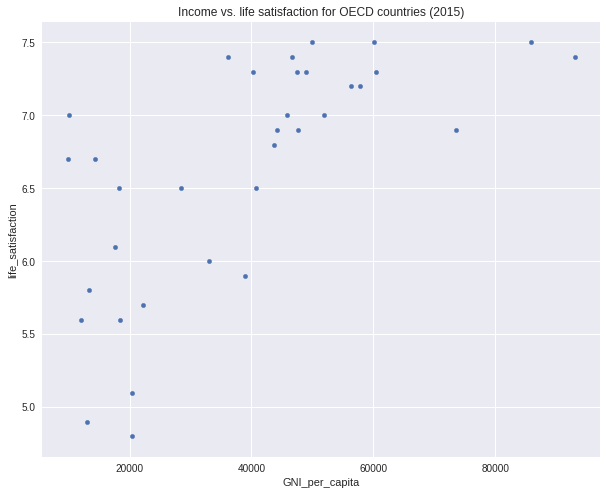

In [16]:
#Scatterplot income vs life satisfaction
fig,ax = plt.subplots(figsize = [10,8])
df.plot(kind='scatter',x='GNI_per_capita',y='life_satisfaction',ax=ax)
plt.title('Income vs. life satisfaction for OECD countries (2015)');

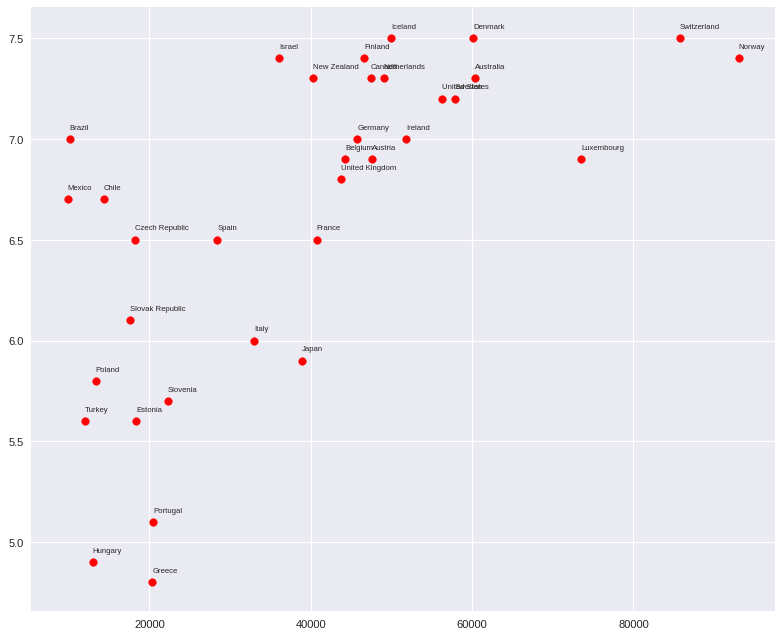

In [17]:
#With annotated data points (make sure figure is imported from matplotlib.pyplot) 

countrylist=df.iloc[:, 0].tolist()
lifesat=df.iloc[:, 1].tolist()
GNIpercapita=df.iloc[:,2].tolist()
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
for i,type in enumerate(countrylist):
    inc = GNIpercapita[i]
    lif = lifesat[i]
    plt.scatter(inc, lif, color='red')
    plt.text(inc+0.05, lif+0.05, type, fontsize=7)
plt.show()

## EXERCISES:

We have looked at the tools Python has for data processing and cleaning, 
now lets explore the available functionality for statistical exploration of the data. 
At this stage, we can use common pandas functions and do things like:

- check the shape of the dataframe, i.e. number of rows and columns *df.shape*
- check the names of the columns *df.columns*
- display the first n observations in a dataframe *df.head(n)* (default is n=5)
- checking data types: *df.dtypes*
- accessing/indexing columns. Two main ways: *df.column_name* or *df[column_name]*
- check distribution of the variables using *df.describe()*
- check summary statistics using *df.mean()* or *df.median()* or *df.min* or *df.max*
- get value counts, mostly useful for categorical variables: *df[col_name].value_counts()*
- sort the data: *df.sort_values*

In case you need to know what each function does in pandas, use this trick to get details: df.function_name?. Try this without including the brackets/parentheses to get documentation about that particular function


Exercise 1: Display descriptive Statistics for the whole dataset (using dataframe.describe()

In [18]:
#Your code here: 
df.describe()

,life_satisfaction,GNI_per_capita
count,34.000000,34.000000
mean,6.623529,38838.529412
std,0.793557,21572.463527
min,4.800000,9840.000000
25%,6.025000,18875.000000
50%,6.900000,40500.000000
75%,7.300000,49727.500000
max,7.500000,93050.000000


Exercise 2: Display the distribution on a histogram (HINT: plt.hist(dataframe.column_name, bins=n) 

(array([7., 5., 2., 4., 8., 3., 2., 1., 0., 2.]),
 array([ 9840., 18161., 26482., 34803., 43124., 51445., 59766., 68087.,
        76408., 84729., 93050.]),
 <a list of 10 Patch objects>)

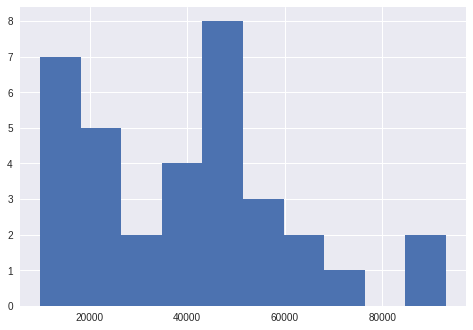

In [19]:
plt.hist(df.GNI_per_capita) 

Exercise 3: What is the maximum GNI per capita in 2015? (using dataframe.col_name.max()

In [20]:
#Your code here:
print (df.GNI_per_capita.max())

93050


Exercise 4: Which country has the lowest score for life satisfaction in 2015?

In [21]:
# Your code here: 
min_sat = (df.life_satisfaction.idxmin())
print(df.loc[min_sat].country)

Greece


In [22]:
# To output the full profile of the country with the minimum GNI: 
df.loc[df['GNI_per_capita'].idxmin()]

country              Mexico
life_satisfaction       6.7
GNI_per_capita         9840
Name: 16, dtype: object

Exercise 5: Try running an OLS regression using the statsmodel library (make sure to import it first!)

In [23]:
#5.1 Enter variable names:
y = df.life_satisfaction
X = df.GNI_per_capita

X = sm.add_constant(X)

model = sm.OLS(y,X).fit()
model.params

const             5.659271
GNI_per_capita    0.000025
dtype: float64

In [24]:
#5.2 Try using the model.summary() function:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      life_satisfaction   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     26.77
Date:                Wed, 13 Feb 2019   Prob (F-statistic):           1.20e-05
Time:                        18:50:07   Log-Likelihood:                -29.540
No. Observations:                  34   AIC:                             63.08
Df Residuals:                      32   BIC:                             66.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.6593      0.212     26.639      0.000       5.227       6.092
GNI_per_capita  2.483e-05    4.8e-06      5.174      0.000    1.51e-05    3.46e-05
==============================================================================
Omnibus:                        1.115   Durbin-Watson:                   1.687
Prob(Omnibus):                  0.573   Jarque-Bera (JB):                1.051
Skew:                          -0.390   Prob(JB):                        0.591
Kurtosis:                       2.635   Cond. No.                     9.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

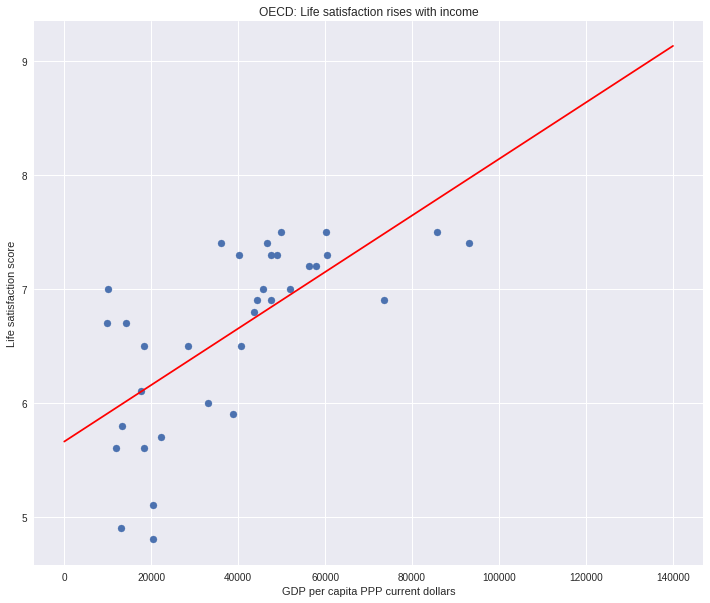

In [25]:
#5.3 Can you display the graph?

fig,ax = plt.subplots(figsize=[12, 10])

ax.scatter(df.GNI_per_capita, df.life_satisfaction)
ax.set(xlabel = 'GDP per capita PPP current dollars', ylabel = 'Life satisfaction score',title='OECD: Life satisfaction rises with income');

X_plot = np.linspace(0,140000,1000)
ax.plot(X_plot, X_plot*model.params[1]+ model.params[0],color='r');

Modelling and Machine Learning

When it comes to building statistical and/or machine learning, Python offers many options. In general, Python has much strong capabilities for Machine Learning models than statistical and econometrics models but they is alot you can with statistical modelling capabilities. Some of the go to libraries for statistical analysis, linear algebra and other scientific computing are: statsmodels, scipy, numpy. If you want to do Machine Learning (Deep Learning included), the following libraries are excellent:

- scikit-learn: a general purpose machine learning library
- TensorFlow/Keras/Theano: Focused more on deep learning and nerural networks
- Apache Spark ML Lib: For distributed machine learning with large datasets
